In [68]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [85]:
from io import BytesIO

from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from matplotlib.transforms import IdentityTransform

In [2]:
attribute_path = "/home/ali/projects/photo_collection/celebface-archive/list_attr_celeba.csv"
partition_path = "/home/ali/projects/photo_collection/celebface-archive/list_eval_partition.csv"
images_path = "/home/ali/projects/photo_collection/celebface-archive/img_align_celeba/img_align_celeba/"
batch_size = 128
Nodel_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2"
image_size = (224, 224)

In [3]:
df_attributes = pd.read_csv(attribute_path)

In [4]:
df_attributes.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [5]:
selected_attributes = ["5_o_Clock_Shadow", "Bald", "Bangs", "Black_Hair", "Blond_Hair", "Brown_Hair",
                       "Eyeglasses", "Goatee", "Gray_Hair", "Male", "Mustache", "No_Beard", "Sideburns", "Smiling", "Straight_Hair", "Wavy_Hair",
                       "Wearing_Earrings", "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace", "Wearing_Necktie"]

In [6]:
column_list = ["image_id"]
column_list.extend(selected_attributes)

In [7]:
df_attributes_selected = df_attributes[df_attributes.columns.intersection(column_list)].copy()

In [8]:
df_attributes_selected.head()

,image_id,5_o_Clock_Shadow,Bald,Bangs,Black_Hair,Blond_Hair,Brown_Hair,Eyeglasses,Goatee,Gray_Hair,...,No_Beard,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie
0,000001.jpg,-1,-1,-1,-1,-1,1,-1,-1,-1,...,1,-1,1,1,-1,1,-1,1,-1,-1
1,000002.jpg,-1,-1,-1,-1,-1,1,-1,-1,-1,...,1,-1,1,-1,-1,-1,-1,-1,-1,-1
2,000003.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,1,-1,-1,-1,-1,-1
3,000004.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,1,-1,1,-1,1,1,-1
4,000005.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,1,-1,-1


In [9]:
df_partition = pd.read_csv(partition_path)

In [10]:
df = pd.merge(df_attributes_selected, df_partition, on="image_id")
df = df.replace(-1,0)
df.head()

,image_id,5_o_Clock_Shadow,Bald,Bangs,Black_Hair,Blond_Hair,Brown_Hair,Eyeglasses,Goatee,Gray_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,partition
0,000001.jpg,0,0,0,0,0,1,0,0,0,...,0,1,1,0,1,0,1,0,0,0
1,000002.jpg,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,000003.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,000004.jpg,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,0
4,000005.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [11]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    return image

In [12]:
def load_and_preprocess_image(path, *args):
    image = tf.io.read_file(path)
    return preprocess_image(image), *args

In [15]:
def build_dataset_from_df(input_df, attr_list):
    b_list = [input_df[attr] for attr in attr_list]
    b_list.insert(0, [images_path + image_id for image_id in input_df["image_id"]])
    a_tuple = tuple(b_list)
    dataset = tf.data.Dataset.from_tensor_slices(a_tuple)
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.shuffle(buffer_size=1000)
    #TODO check the effect of dataset.repeat()
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [19]:
train_df = df.loc[df["partition"] == 0]
#TODO remove these to use all instances when you made sure it is working
train_df = train_df.sample(n=5000)
train_ds = build_dataset_from_df(train_df, selected_attributes)

val_df = df.loc[df["partition"] == 1]
val_df = val_df.sample(n=1000)
val_ds = build_dataset_from_df(val_df, selected_attributes)

In [20]:
list(train_ds.take(1).as_numpy_iterator())

2023-04-12 09:56:04.414083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [5000]
	 [[{{node Placeholder/_4}}]]
2023-04-12 09:56:04.415257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [5000]
	 [[{{node Placeholder/_4}}]]


[(array([[[[2.39000000e+02, 2.47000000e+02, 2.49000000e+02],
           [2.39000000e+02, 2.47000000e+02, 2.49000000e+02],
           [2.39000000e+02, 2.47000000e+02, 2.49000000e+02],
           ...,
           [2.41000000e+02, 2.46000000e+02, 2.40000000e+02],
           [2.41000000e+02, 2.46000000e+02, 2.40000000e+02],
           [2.41000000e+02, 2.46000000e+02, 2.40000000e+02]],
  
          [[2.39000000e+02, 2.47000000e+02, 2.49000000e+02],
           [2.39000000e+02, 2.47000000e+02, 2.49000000e+02],
           [2.39000000e+02, 2.47000000e+02, 2.49000000e+02],
           ...,
           [2.41000000e+02, 2.46000000e+02, 2.40000000e+02],
           [2.41000000e+02, 2.46000000e+02, 2.40000000e+02],
           [2.41000000e+02, 2.46000000e+02, 2.40000000e+02]],
  
          [[2.39000000e+02, 2.47000000e+02, 2.49000000e+02],
           [2.39000000e+02, 2.47000000e+02, 2.49000000e+02],
           [2.39000000e+02, 2.47000000e+02, 2.49000000e+02],
           ...,
           [2.41000000e+02, 2

In [49]:
next_batch = next(iter(train_ds))

In [50]:
print (f"Image shape: {next_batch[0][1].numpy().shape}")
for i in range(len(selected_attributes)):
    print (f"{selected_attributes[i]} shape: {next_batch[i+1].shape}")

Image shape: (224, 224, 3)
5_o_Clock_Shadow shape: (128,)
Bald shape: (128,)
Bangs shape: (128,)
Black_Hair shape: (128,)
Blond_Hair shape: (128,)
Brown_Hair shape: (128,)
Eyeglasses shape: (128,)
Goatee shape: (128,)
Gray_Hair shape: (128,)
Male shape: (128,)
Mustache shape: (128,)
No_Beard shape: (128,)
Sideburns shape: (128,)
Smiling shape: (128,)
Straight_Hair shape: (128,)
Wavy_Hair shape: (128,)
Wearing_Earrings shape: (128,)
Wearing_Hat shape: (128,)
Wearing_Lipstick shape: (128,)
Wearing_Necklace shape: (128,)
Wearing_Necktie shape: (128,)


In [105]:
def text_to_rgba(some_str, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none")
    fig.text(0, 0, some_str, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba_out = plt.imread(buf)
    return rgba_out

<Figure size 640x480 with 0 Axes>

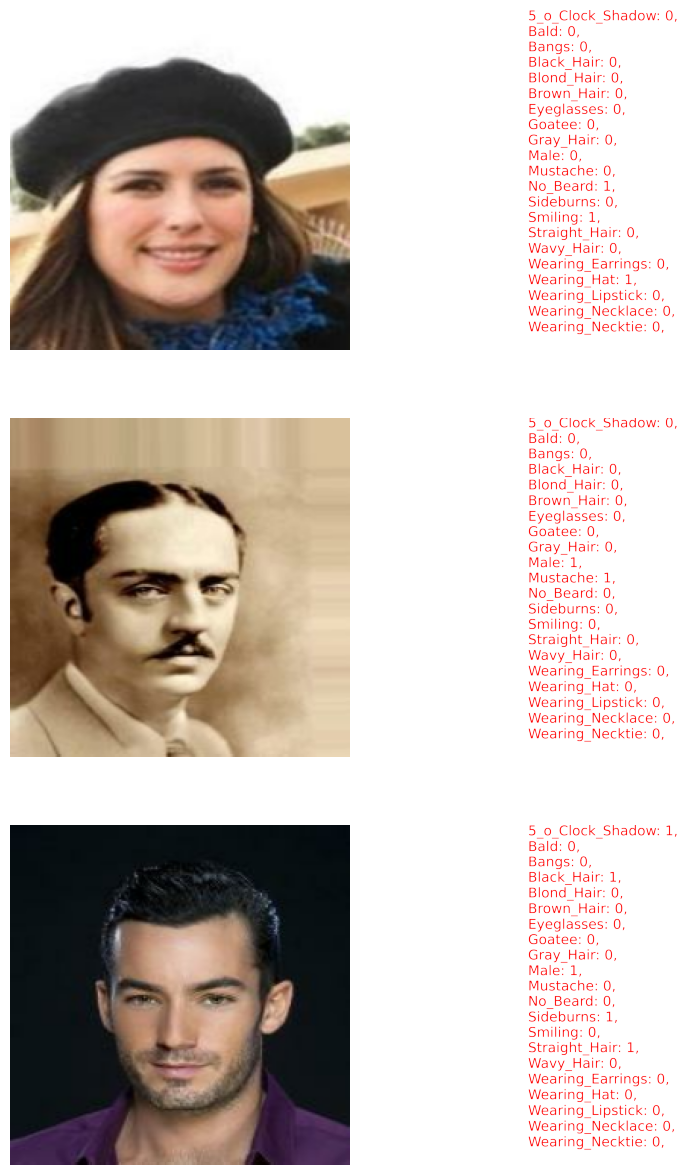

In [113]:
next_batch = next(iter(train_ds))
plt.tight_layout()
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    axs[i, 0].imshow(next_batch[0][i].numpy().astype("uint8"))
    axs[i, 0].axis("off")
    s = ""
    for j in range (len(selected_attributes)):
        s = s + f"{selected_attributes[j]}: {next_batch[j+1][i].numpy()},\n"
    rgba = text_to_rgba(s, color="red", fontsize=50, dpi=200)
    axs[i, 1].imshow(rgba)
    axs[i, 1].axis("off")